In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D  
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE

In [175]:
df = pd.read_csv('telco.csv')

In [111]:
df.head(3)

,Customer ID,Gender,Age,Under 30,Senior Citizen,Married,Dependents,Number of Dependents,Country,State,...,Total Extra Data Charges,Total Long Distance Charges,Total Revenue,Satisfaction Score,Customer Status,Churn Label,Churn Score,CLTV,Churn Category,Churn Reason
0,8779-QRDMV,Male,78,No,Yes,No,No,0,United States,California,...,20,0.00,59.65,3,Churned,Yes,91,5433,Competitor,Competitor offered more data
1,7495-OOKFY,Female,74,No,Yes,Yes,Yes,1,United States,California,...,0,390.80,1024.10,3,Churned,Yes,69,5302,Competitor,Competitor made better offer
2,1658-BYGOY,Male,71,No,Yes,No,Yes,3,United States,California,...,0,203.94,1910.88,2,Churned,Yes,81,3179,Competitor,Competitor made better offer


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 50 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Under 30                           7043 non-null   object 
 4   Senior Citizen                     7043 non-null   object 
 5   Married                            7043 non-null   object 
 6   Dependents                         7043 non-null   object 
 7   Number of Dependents               7043 non-null   int64  
 8   Country                            7043 non-null   object 
 9   State                              7043 non-null   object 
 10  City                               7043 non-null   object 
 11  Zip Code                           7043 non-null   int64

In [115]:
df.isnull().sum()

Customer ID                             0
Gender                                  0
Age                                     0
Under 30                                0
Senior Citizen                          0
Married                                 0
Dependents                              0
Number of Dependents                    0
Country                                 0
State                                   0
City                                    0
Zip Code                                0
Latitude                                0
Longitude                               0
Population                              0
Quarter                                 0
Referred a Friend                       0
Number of Referrals                     0
Tenure in Months                        0
Offer                                3877
Phone Service                           0
Avg Monthly Long Distance Charges       0
Multiple Lines                          0
Internet Service                  

# จำนวนของคนที่ยกเลิกบริการและไม่ยกเลิกบริการ

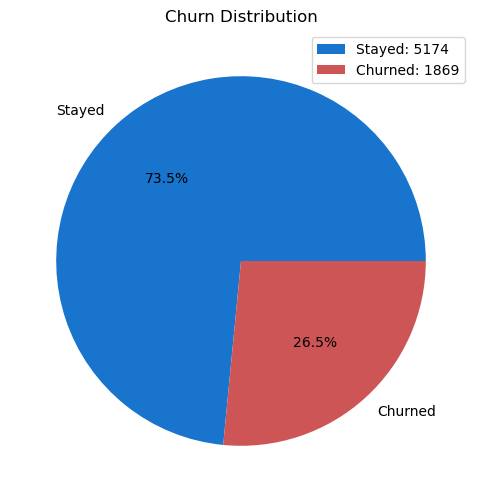

In [118]:
churn_counts = df["Churn Label"].replace({"Yes": "Churned", "No": "Stayed"}).value_counts()
plt.figure(figsize=(10, 6))
plt.pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', colors=["#1874CD", "#CD5555"])
plt.title("Churn Distribution")
plt.legend([f"{label}: {count}" for label, count in churn_counts.items()])
plt.show()

# การให้คะแนน และจำนวนของคนที่ยกเลิกบริการและไม่ยกเลิกบริการ

In [121]:
df['Satisfaction Score'].value_counts()
df.groupby('Satisfaction Score')['Churn Label'].value_counts()

Satisfaction Score  Churn Label
1                   Yes             922
2                   Yes             518
3                   No             2236
                    Yes             429
4                   No             1789
5                   No             1149
Name: count, dtype: int64

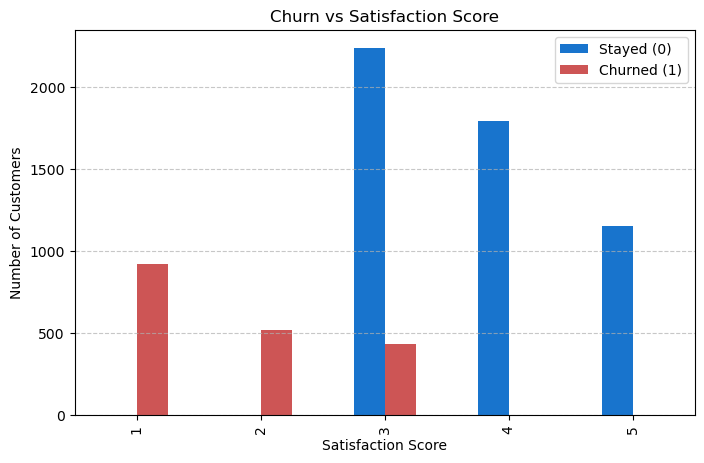

In [123]:
churn_counts = df.groupby(["Satisfaction Score", "Churn Label"]).size().unstack()
churn_counts.plot(kind="bar", figsize=(8, 5), color=["#1874CD", "#CD5555"])
plt.xlabel("Satisfaction Score")
plt.ylabel("Number of Customers")
plt.title("Churn vs Satisfaction Score")
plt.legend(["Stayed (0)", "Churned (1)"])
plt.grid(axis="y", linestyle="--", alpha=0.7)

# ภาพรวมค่าใช้จ่ายรายเดือน

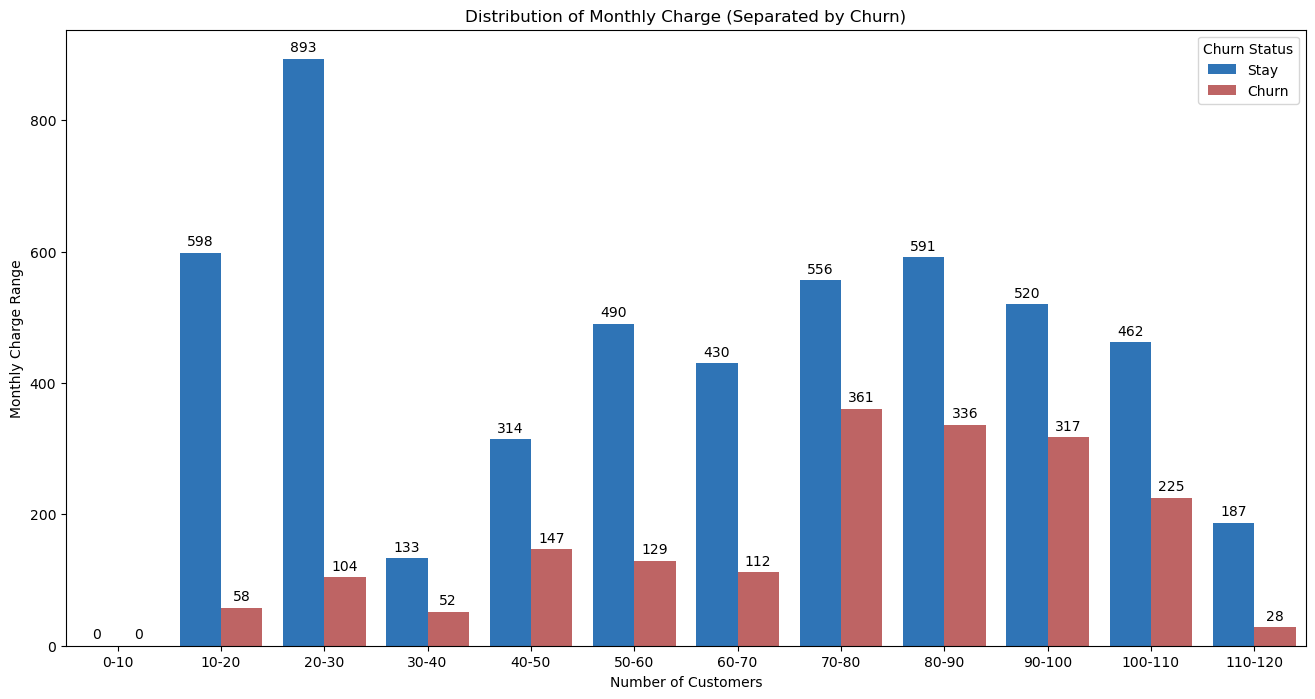

In [126]:
bins = list(range(0, int(df['Monthly Charge'].max()) + 10, 10))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

df['Monthly Charge Binned'] = pd.cut(df['Monthly Charge'], bins=bins, labels=labels, include_lowest=True)

churn_summary = df.groupby(['Monthly Charge Binned', 'Churn Label'], observed=False).size().reset_index(name='Customer Count')

plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x='Monthly Charge Binned', 
    y='Customer Count', 
    hue='Churn Label', 
    data=churn_summary, 
    palette=["#1874CD", "#CD5555"]
)

plt.xlabel("Number of Customers")
plt.ylabel("Monthly Charge Range")
plt.title("Distribution of Monthly Charge (Separated by Churn)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Stay', 'Churn'], title="Churn Status", loc='upper right')

for container in plt.gca().containers:
    plt.bar_label(container, fmt="%d", label_type="edge", fontsize=10, padding=3)
plt.show()

# ค่าใช้จ่ายทั้งหมด

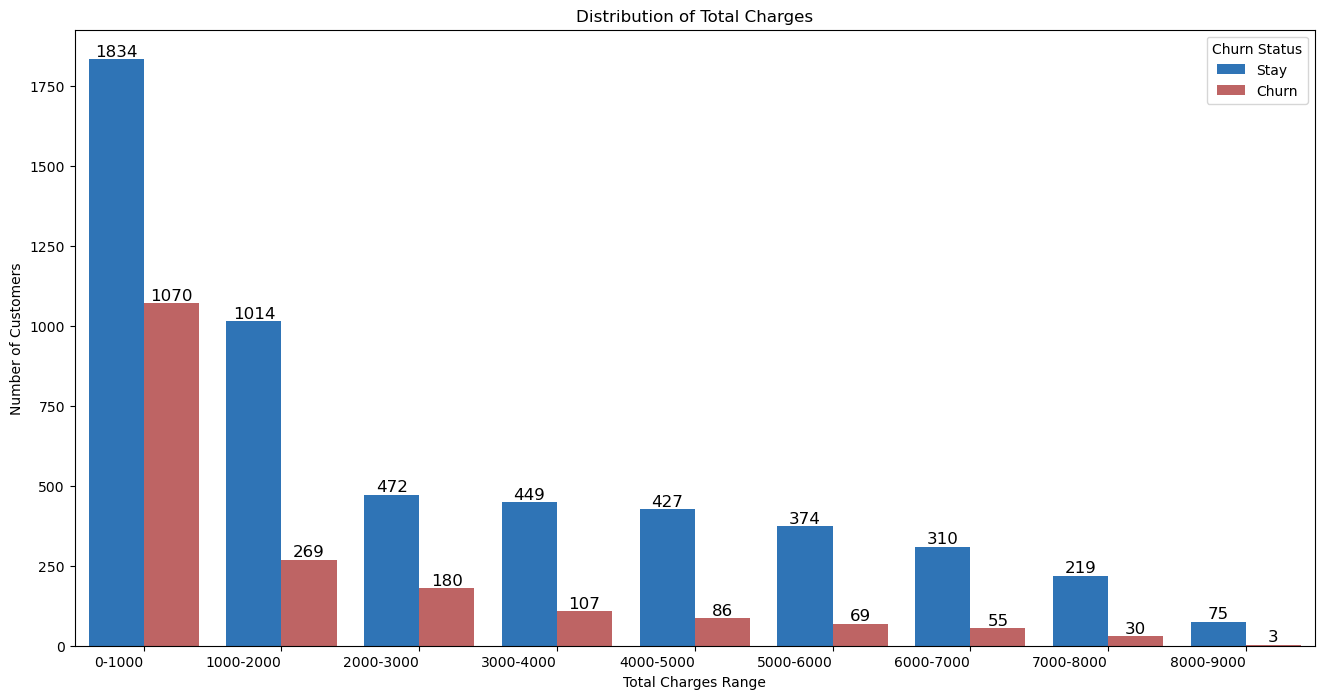

In [129]:
bins = list(range(0, int(df['Total Charges'].max()) + 1000, 1000))
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

df['Total Charges Binned'] = pd.cut(df['Total Charges'], bins=bins, labels=labels, include_lowest=True)

churn_summary = df.groupby(['Total Charges Binned', 'Churn Label'], observed=True).size().reset_index(name='Customer Count')

plt.figure(figsize=(16, 8))
ax = sns.barplot(
    x='Total Charges Binned', 
    y='Customer Count', 
    hue='Churn Label', 
    data=churn_summary, 
    palette=["#1874CD", "#CD5555"]
)

plt.xticks(ha='right')
plt.xlabel("Total Charges Range")
plt.ylabel("Number of Customers")
plt.title("Distribution of Total Charges")

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Stay', 'Churn'], title="Churn Status", loc='upper right')

for container in ax.containers:
    plt.bar_label(container, fmt="%d", label_type="edge", fontsize=12)
plt.show()

# ช่วงอายุที่มีคนให้คะแนน 1-3 คะแนน (Churn)

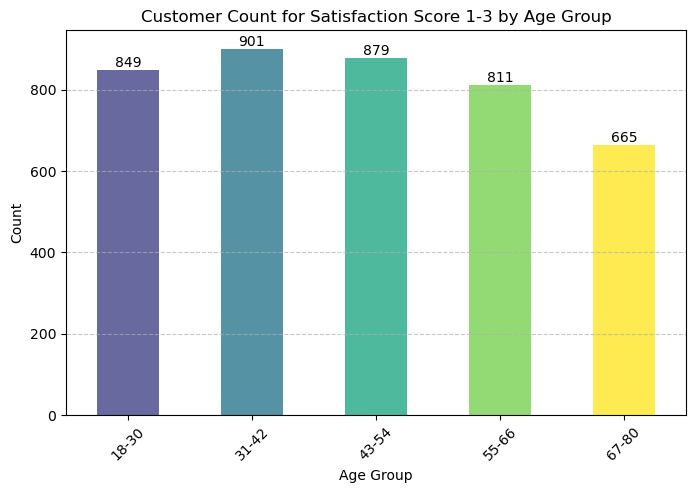

ช่วงอายุที่มีลูกค้าให้คะแนน 1-3 มากที่สุดคือ: 31-42


In [132]:
filtered_df = df[df["Satisfaction Score"].between(1, 3)].copy()
age_bins = [18, 30, 42, 54, 66, 80]
age_labels = ["18-30", "31-42", "43-54", "55-66", "67-80"]
filtered_df.loc[:, "Age Group"] = pd.cut(filtered_df["Age"], bins=age_bins, labels=age_labels, right=True)
age_counts = filtered_df["Age Group"].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.2, 1, len(age_counts)))
plt.figure(figsize=(8, 5))
bars = age_counts.plot(kind="bar", color=colors, alpha=0.8)

plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Customer Count for Satisfaction Score 1-3 by Age Group")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for bar, count in zip(bars.patches, age_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}", 
             ha="center", va="bottom", fontsize=10, color="black")

plt.show()
most_common_age_group = age_counts.idxmax()
print("ช่วงอายุที่มีลูกค้าให้คะแนน 1-3 มากที่สุดคือ:", most_common_age_group)

# ช่วงอายุที่มีคนให้คะแนน 4-5 คะแนน (Stay)

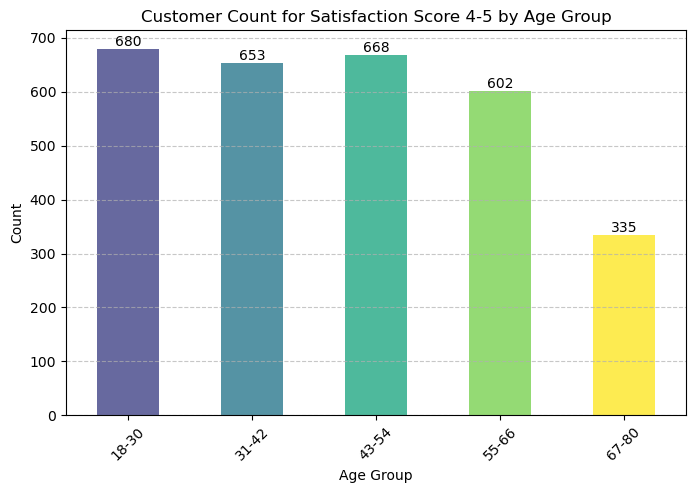

ช่วงอายุที่มีลูกค้าให้คะแนน 4-5 มากที่สุดคือ: 18-30


In [135]:
filtered_df2 = df[df["Satisfaction Score"].between(4, 5)].copy()
age_bins = [18, 30, 42, 54, 66, 80]
age_labels = ["18-30", "31-42", "43-54", "55-66", "67-80"]
filtered_df2.loc[:, "Age Group"] = pd.cut(filtered_df2["Age"], bins=age_bins, labels=age_labels, right=True)
age_counts = filtered_df2["Age Group"].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0.2, 1, len(age_counts)))
plt.figure(figsize=(8, 5))
bars = age_counts.plot(kind="bar", color=colors, alpha=0.8)

plt.xlabel("Age Group")
plt.ylabel("Count")
plt.title("Customer Count for Satisfaction Score 4-5 by Age Group")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for bar, count in zip(bars.patches, age_counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{count:,}", 
             ha="center", va="bottom", fontsize=10, color="black")

plt.show()
most_common_age_group = age_counts.idxmax()
print("ช่วงอายุที่มีลูกค้าให้คะแนน 4-5 มากที่สุดคือ:", most_common_age_group)

# ช่วงอายุ 31-42 มีการใช้ Contract ประเภทใดมากที่สุด

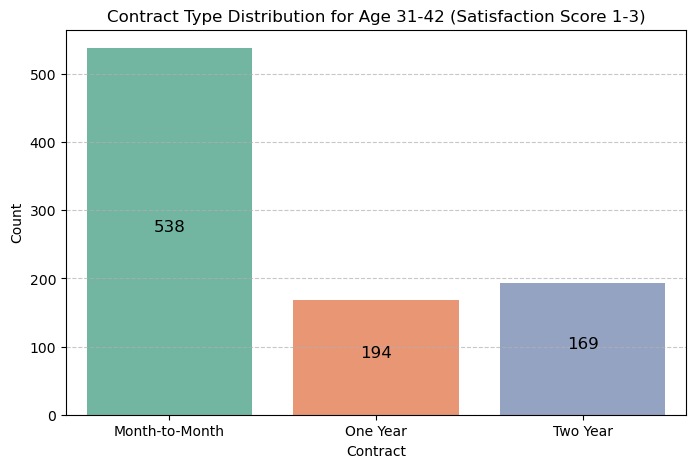

In [138]:
age_31_42_df = df[(df["Satisfaction Score"].between(1, 3)) & (df["Age"].between(31, 42))]

plt.figure(figsize=(8, 5))
sns.countplot(data=age_31_42_df, x="Contract", hue="Contract", palette="Set2", legend=False)
contract_counts = age_31_42_df["Contract"].value_counts()
for i, count in enumerate(contract_counts):
    patch = plt.gca().patches[i]
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height / 2, str(count), ha="center", fontsize=12)

plt.xlabel("Contract")
plt.ylabel("Count")
plt.title("Contract Type Distribution for Age 31-42 (Satisfaction Score 1-3)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# กลุ่ม Month-to-Month ในช่วงอายุ 31-42 มีการใช้งานกี่เดือน

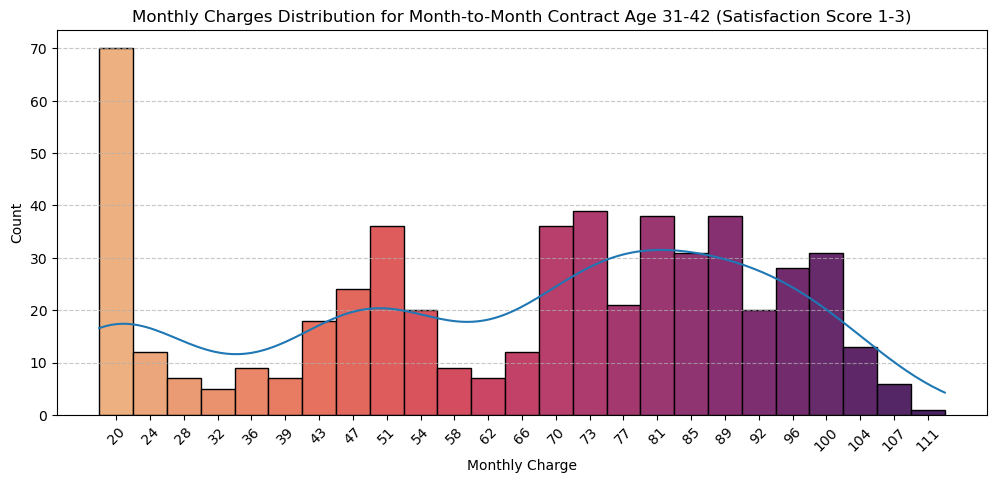

In [141]:
month_to_month_df = age_31_42_df[age_31_42_df["Contract"] == "Month-to-Month"]
plt.figure(figsize=(12, 5))
ax = sns.histplot(month_to_month_df["Monthly Charge"], bins=25, kde=True)

cmap = plt.get_cmap("flare")
patches = ax.patches
colors = cmap(np.linspace(0, 1, len(patches)))

for patch, color in zip(patches, colors):
    patch.set_facecolor(color)

bin_centers = [(patch.get_x() + patch.get_width() / 2) for patch in patches]
plt.xticks(bin_centers, [f"{int(x)}" for x in bin_centers], rotation=45)
bin_edges = plt.gca().patches[0].get_x()
bin_centers = [(patch.get_x() + patch.get_width() / 2) for patch in plt.gca().patches]
plt.xticks(bin_centers, [f"{int(x)}" for x in bin_centers])
plt.xlabel("Monthly Charge")
plt.ylabel("Count")
plt.title("Monthly Charges Distribution for Month-to-Month Contract Age 31-42 (Satisfaction Score 1-3)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# การใช้งานแพ็คเกจของผู้ใช้ที่อายุ 31-42 ปี ที่ Churn

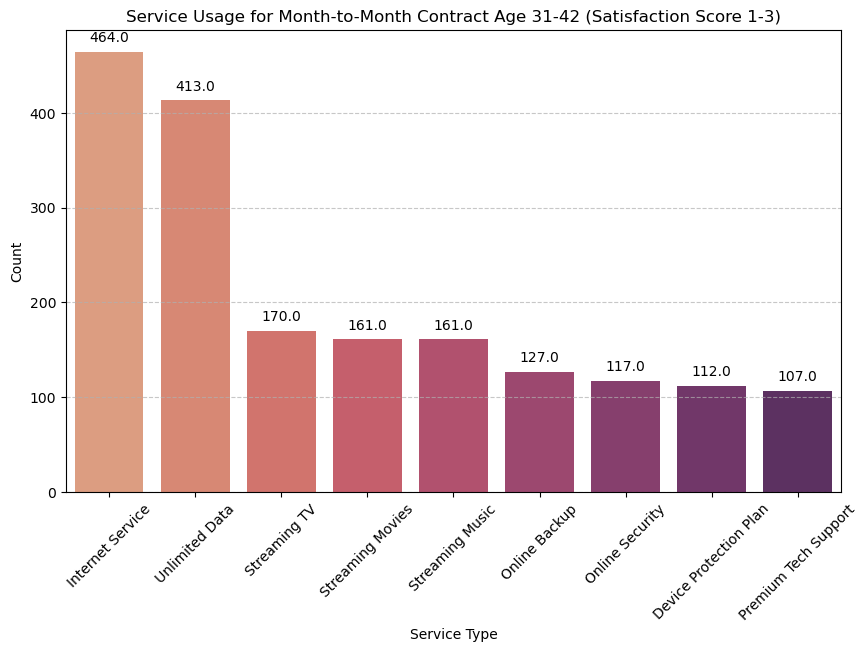

In [144]:
service_columns = [
    "Internet Service", "Streaming TV", "Streaming Movies", "Streaming Music", "Unlimited Data",
    "Online Security", "Device Protection Plan", "Premium Tech Support", "Online Backup"
]

month_to_month_df = age_31_42_df[age_31_42_df["Contract"] == "Month-to-Month"]
service_counts = month_to_month_df[service_columns].apply(lambda col: (col == "Yes").sum()).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=service_counts.index, y=service_counts.values, hue=service_counts.index, palette="flare", legend=False)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                xytext=(0, 10), 
                textcoords='offset points', 
                ha='center', va='center', 
                fontsize=10, color='black')
plt.xlabel("Service Type")
plt.ylabel("Count")
plt.title("Service Usage for Month-to-Month Contract Age 31-42 (Satisfaction Score 1-3)")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# สถานะการแต่งงานมีจำนวนการ Churn เท่าไหร่

In [147]:
df['Married'].value_counts()
df.groupby('Married')['Churn Label'].value_counts()

Married  Churn Label
No       No             2441
         Yes            1200
Yes      No             2733
         Yes             669
Name: count, dtype: int64

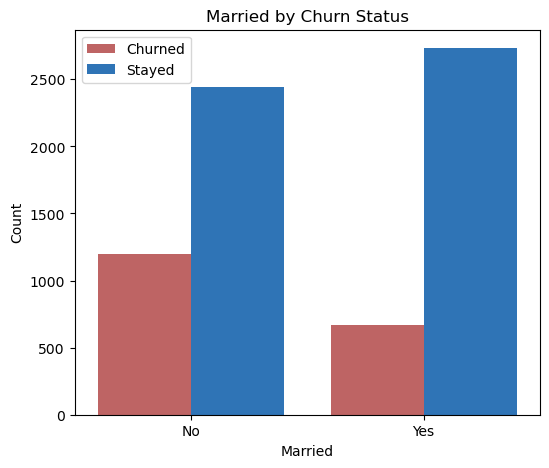

In [149]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Married', hue='Churn Label', palette={'Yes': '#CD5555', 'No': '#1874CD'})
plt.title('Married by Churn Status')
plt.xlabel('Married')
plt.ylabel('Count')
plt.legend(labels=['Churned', 'Stayed'])

# รูปแบบสัญญาของลูกค้าที่ยังไม่แต่งงาน และมีการ Churn

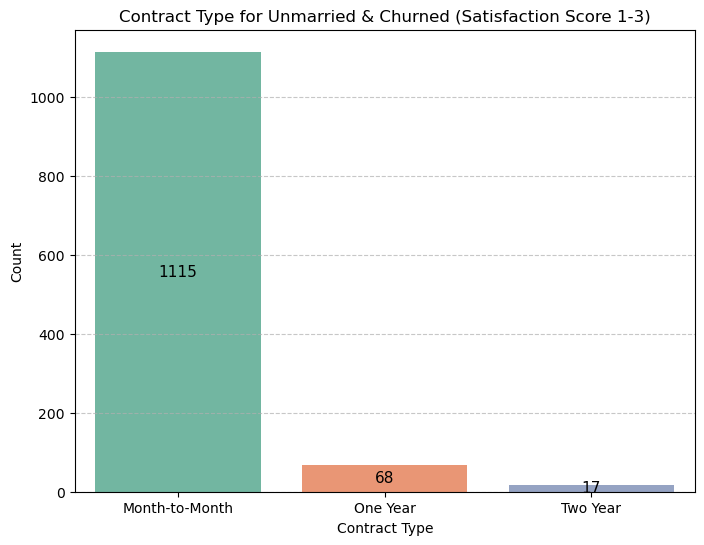

In [152]:
filtered_df = df[(df['Married'] == 'No') & (df['Churn Label'] == 'Yes')]
filtered_df = filtered_df[filtered_df['Satisfaction Score'].between(1, 3)]

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=filtered_df, x='Contract', hue='Contract', palette='Set2', legend=False)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height / 2), 
                    ha='center', va='center', fontsize=11, color='black')

plt.title('Contract Type for Unmarried & Churned (Satisfaction Score 1-3)')
plt.xlabel('Contract Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# ระยะเวลาการเป็นลูกค้าของลูกค้าที่ยังไม่แต่งงาน และมีการ Churn

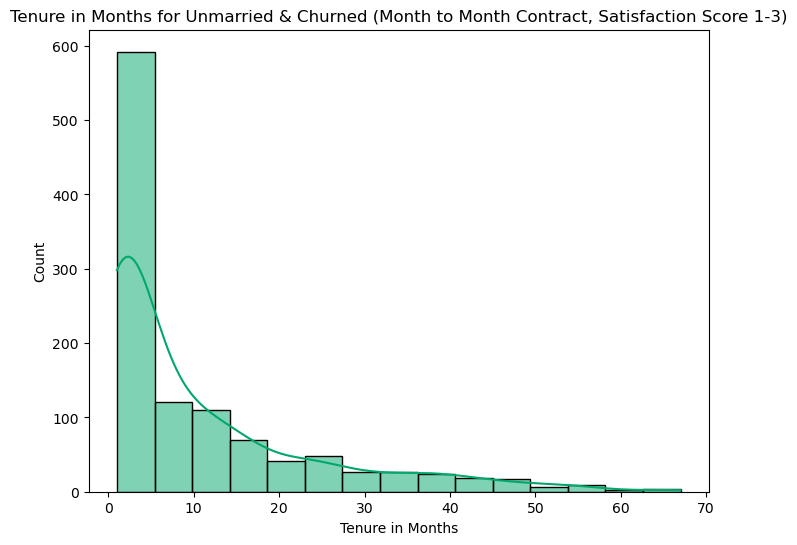

In [155]:
filtered_df = df[(df['Married'] == 'No') & 
                 (df['Churn Label'] == 'Yes') & 
                 (df['Contract'] == 'Month-to-Month') & 
                 (df['Satisfaction Score'].isin([1, 2, 3]))]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_df['Tenure in Months'], kde=True, color='#00a86b', bins=15)
plt.title('Tenure in Months for Unmarried & Churned (Month to Month Contract, Satisfaction Score 1-3)')
plt.xlabel('Tenure in Months')
plt.ylabel('Count')
plt.show()

# กลุ่มลูกค้าที่ยังไม่แต่งงาน (Churn) ที่มีรูปแบบสัญญาแบบ Month-to-Month และให้คะแนนความพึงพอใจ 1-3 

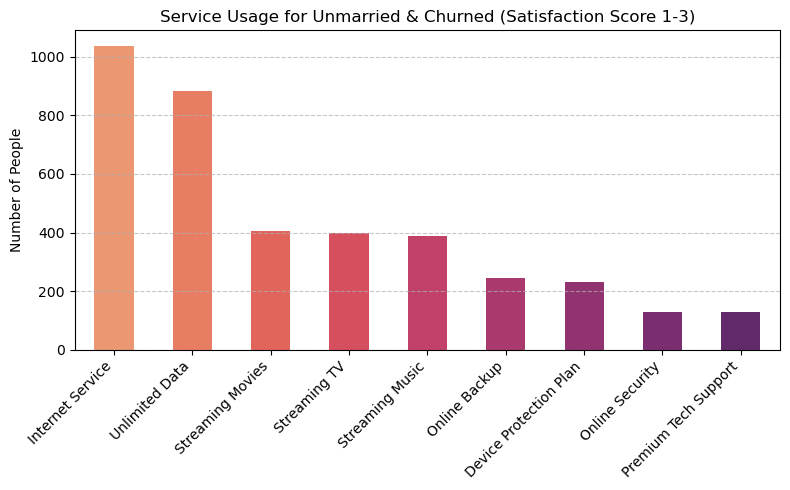

In [177]:
df_filtered = df[(df['Married'] == 'No') & (df['Churn Label'] == 'Yes') & (df['Contract'] == 'Month-to-Month') & (df['Satisfaction Score'].isin([1, 2, 3]))]

service_columns = ['Internet Service', 'Online Security', 
                   'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
                   'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']

df_usage_combined11 = df_filtered[service_columns].apply(lambda x: (x == 'Yes').sum()).sort_values(ascending=False)

colors = sns.color_palette("flare", len(df_usage_combined11))
plt.figure(figsize=(8, 5))
df_usage_combined11.plot(kind='bar', color=colors, title="Service Usage for Unmarried & Churned (Satisfaction Score 1-3)")
plt.ylabel("Number of People")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [180]:
df_usage_combined11.to_frame(name='Number of People')

,Number of People
Internet Service,1039
Unlimited Data,882
Streaming Movies,404
Streaming TV,400
Streaming Music,388
Online Backup,244
Device Protection Plan,230
Online Security,128
Premium Tech Support,127


# กลุ่มลูกค้าที่ยังไม่แต่งงาน (Stay) ที่มีรูปแบบสัญญาแบบ Month-to-Month และให้คะแนนความพึงพอใจ 4-5

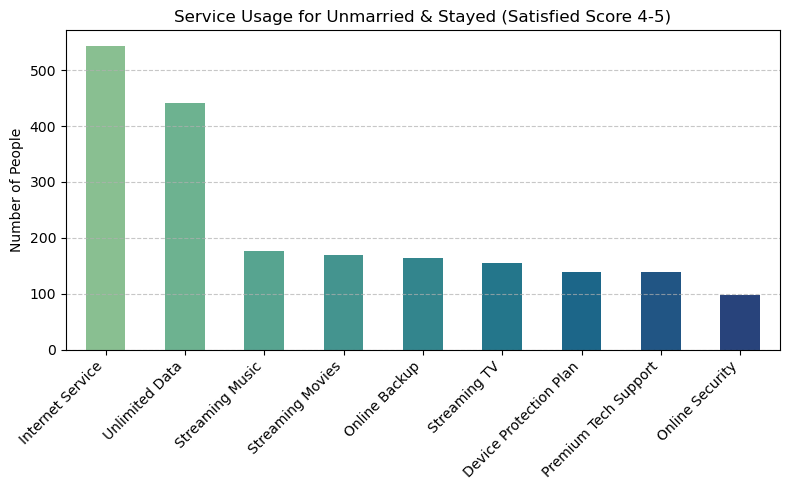

In [182]:
df_filtered = df[(df['Married'] == 'No') & (df['Churn Label'] == 'No') & (df['Contract'] == 'Month-to-Month') & (df['Satisfaction Score'].isin([4, 5]))]

service_columns = ['Internet Service', 'Online Security', 
                   'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
                   'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data']

df_usage_combined22 = df_filtered[service_columns].apply(lambda x: (x == 'Yes').sum()).sort_values(ascending=False)

colors = sns.color_palette("crest", len(df_usage_combined22))
plt.figure(figsize=(8, 5))
df_usage_combined22.plot(kind='bar', color=colors, title="Service Usage for Unmarried & Stayed (Satisfied Score 4-5)")
plt.ylabel("Number of People")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [184]:
df_usage_combined22.to_frame(name='Number of People')

,Number of People
Internet Service,544
Unlimited Data,441
Streaming Music,177
Streaming Movies,170
Online Backup,164
Streaming TV,155
Device Protection Plan,139
Premium Tech Support,139
Online Security,97


# 5 อันดับเมืองที่มีการให้คะแนนความพึงพอใจ 1-5 คะแนน  

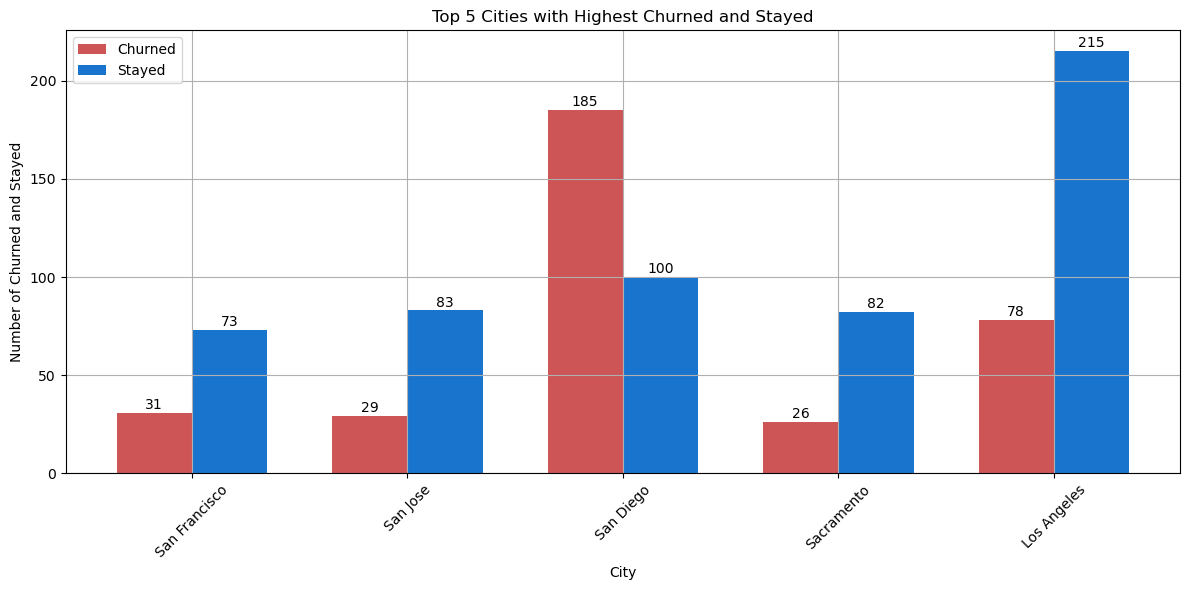

In [161]:
filtered_df = df[(df['Satisfaction Score'] >= 1) & (df['Satisfaction Score'] <= 5)]

# แยกข้อมูล Churn (Yes) และ Non-Churn (No)
churn_df = filtered_df[filtered_df['Churn Label'] == 'Yes']
non_churn_df = filtered_df[filtered_df['Churn Label'] == 'No']

churn_by_city = churn_df['City'].value_counts()
non_churn_by_city = non_churn_df['City'].value_counts()

top_5_churn_cities = churn_by_city.head(5)
top_5_non_churn_cities = non_churn_by_city.head(5)

top_5_churn_cities.index = top_5_churn_cities.index.astype(str)
top_5_non_churn_cities.index = top_5_non_churn_cities.index.astype(str)

# เลือก 5 เมืองที่มีการ Churn และ Non-Churn สูงสุดรวมกัน
cities = list(set(top_5_churn_cities.index) | set(top_5_non_churn_cities.index))

plt.figure(figsize=(12, 6))
churn_values = [churn_by_city.get(city, 0) for city in cities]
non_churn_values = [non_churn_by_city.get(city, 0) for city in cities]
width = 0.35  
x = range(len(cities))  
bars_churn = plt.bar(x, churn_values, width, label='Churned', color='#CD5555')
bars_non_churn = plt.bar([p + width for p in x], non_churn_values, width, label='Stayed', color='#1874CD')

for bar in bars_churn:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), 
             ha='center', va='bottom')  # Churned

for bar in bars_non_churn:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, str(int(height)), 
             ha='center', va='bottom')  # Stayed

plt.xlabel('City')
plt.ylabel('Number of Churned and Stayed')
plt.title('Top 5 Cities with Highest Churned and Stayed')
plt.xticks([p + width / 2 for p in x], cities, rotation=45)  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 5 อันดับเมืองที่มีการ Churned มีการใช้ Service อะไรบ้าง

               Internet Service  Phone Service  Streaming TV  \
City                                                           
Los Angeles                 225            259           114   
Sacramento                   79             99            43   
San Diego                   259            259           130   
San Francisco                74             99            38   
San Jose                     94             99            42   

               Streaming Movies  Streaming Music  Unlimited Data  \
City                                                               
Los Angeles                 103               91             195   
Sacramento                   35               36              66   
San Diego                   113              103             225   
San Francisco                43               37              62   
San Jose                     41               41              80   

               Online Security  Device Protection Plan  Premium Tech Suppo

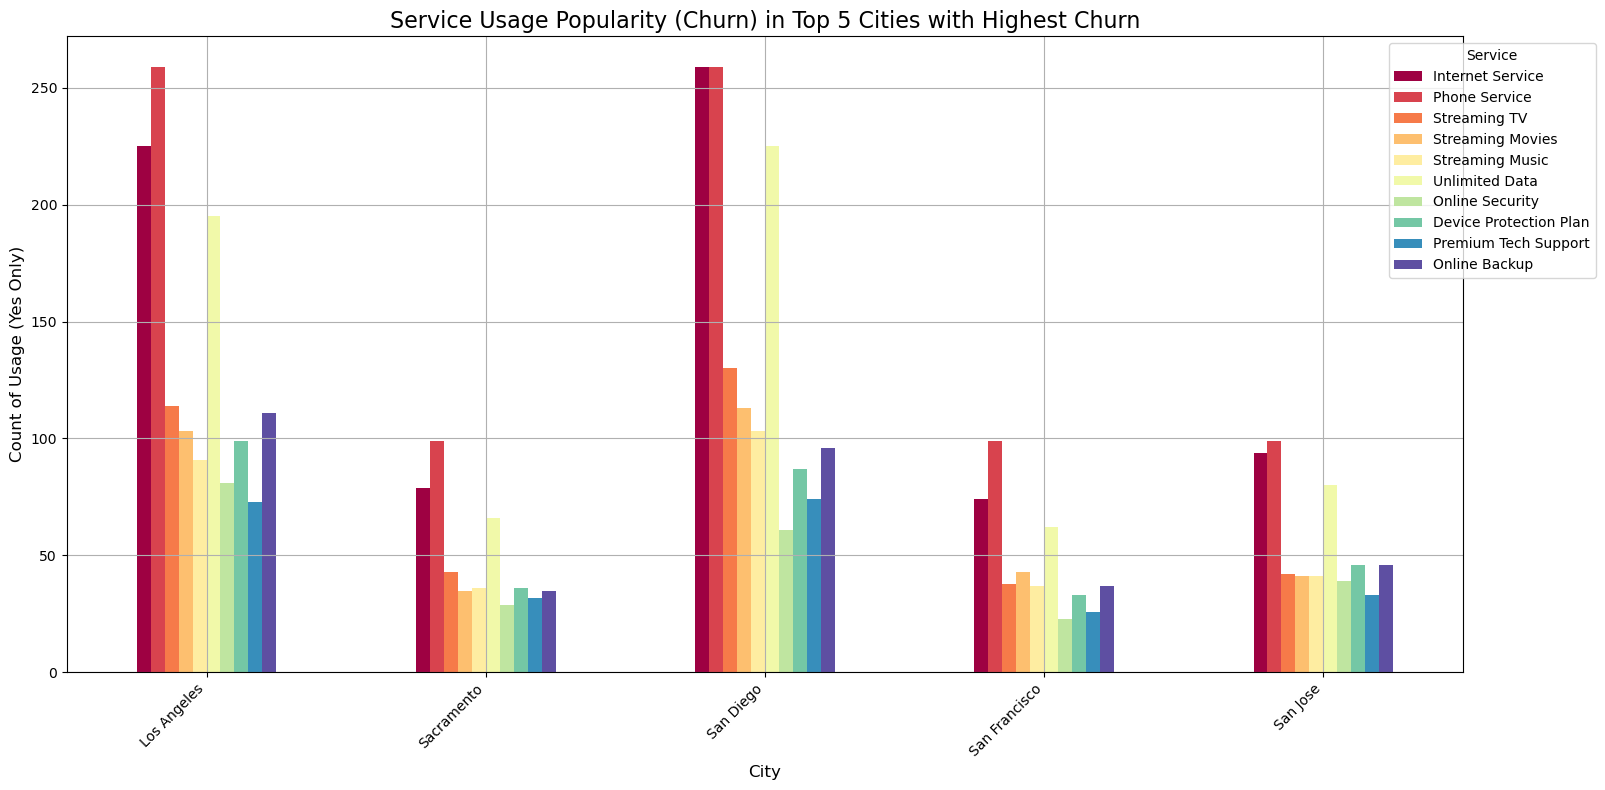

In [164]:
top_5_cities = df.groupby('City')['Churn Label'].value_counts().unstack().fillna(0)
top_5_cities = top_5_cities.sort_values(by='Yes', ascending=False).head(5)
filtered_df = df[df['City'].isin(top_5_cities.index)]
cities_of_interest = ['San Diego', 'Los Angeles', 'San Francisco', 'Sacramento', 'San Jose']
filtered_df = filtered_df[filtered_df['City'].isin(cities_of_interest)]

service_columns = ['Internet Service', 'Phone Service', 'Streaming TV', 'Streaming Movies', 
                   'Streaming Music', 'Unlimited Data', 'Online Security', 'Device Protection Plan', 
                   'Premium Tech Support', 'Online Backup']

filtered_services_df = filtered_df[service_columns].apply(lambda x: x[x == 'Yes'])
city_service_usage = filtered_services_df.groupby(filtered_df['City']).count()

print(city_service_usage)

city_service_usage.plot(kind='bar', figsize=(16, 8), colormap='Spectral')

plt.grid()
plt.title('Service Usage Popularity (Churn) in Top 5 Cities with Highest Churn', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Count of Usage (Yes Only)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Service', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

# 5 อันดับเมืองที่มีการใช้ Service อะไรมากที่สุด

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14160\3994591257.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_convert] = df[columns_to_convert].replace({'Yes': 1, 'No': 0}).astype(int)


               Device Protection Plan  Internet Service  Online Backup  \
San Diego                         NaN             259.0            NaN   
Los Angeles                       NaN             225.0          111.0   
San Francisco                     NaN              74.0            NaN   
Sacramento                        NaN              79.0            NaN   
San Jose                         46.0              94.0           46.0   

               Phone Service  Streaming Movies  Streaming Music  Streaming TV  \
San Diego              259.0             113.0              NaN         130.0   
Los Angeles            259.0               NaN              NaN         114.0   
San Francisco           99.0              43.0              NaN          38.0   
Sacramento              99.0               NaN             36.0          43.0   
San Jose                99.0               NaN              NaN           NaN   

               Unlimited Data  
San Diego               225.0  
Los 

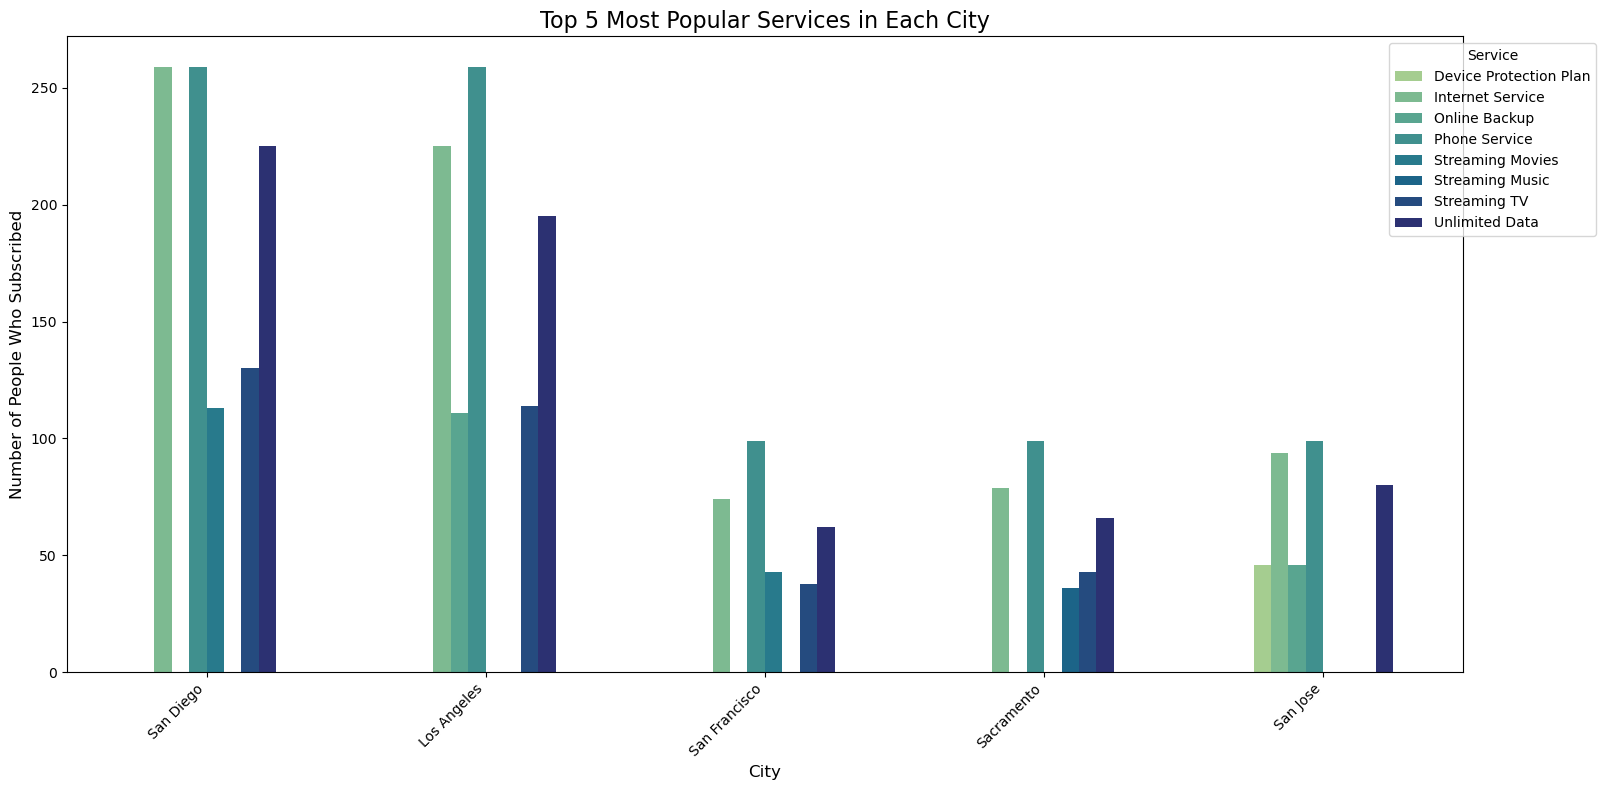

In [167]:
columns_to_convert = ['Internet Service', 'Phone Service', 'Streaming TV', 'Streaming Movies', 
                   'Streaming Music', 'Unlimited Data', 'Online Security', 'Device Protection Plan', 
                   'Premium Tech Support', 'Online Backup']
df[columns_to_convert] = df[columns_to_convert].replace({'Yes': 1, 'No': 0}).astype(int)
cities_of_interest = ['San Diego', 'Los Angeles', 'San Francisco', 'Sacramento', 'San Jose']
top_services_per_city = {}

for city in cities_of_interest:
    city_data = df[df['City'] == city]
    service_counts = city_data[columns_to_convert].sum()
    top_5_services = service_counts.nlargest(5)
    top_services_per_city[city] = top_5_services

top_services_df = pd.DataFrame(top_services_per_city).T
print(top_services_df)
top_services_df.plot(kind='bar', figsize=(16, 8), colormap='crest')
plt.title('Top 5 Most Popular Services in Each City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of People Who Subscribed', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Service', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

# 5 อันดับเมืองที่มีการใช้ Service อะไรน้อยที่สุด

               Device Protection Plan  Online Backup  Online Security  \
San Diego                        87.0           96.0             61.0   
Los Angeles                      99.0            NaN             81.0   
San Francisco                    33.0           37.0             23.0   
Sacramento                       36.0           35.0             29.0   
San Jose                          NaN            NaN             39.0   

               Premium Tech Support  Streaming Movies  Streaming Music  \
San Diego                      74.0               NaN            103.0   
Los Angeles                    73.0             103.0             91.0   
San Francisco                  26.0               NaN             37.0   
Sacramento                     32.0              35.0              NaN   
San Jose                       33.0              41.0             41.0   

               Streaming TV  
San Diego               NaN  
Los Angeles             NaN  
San Francisco           Na

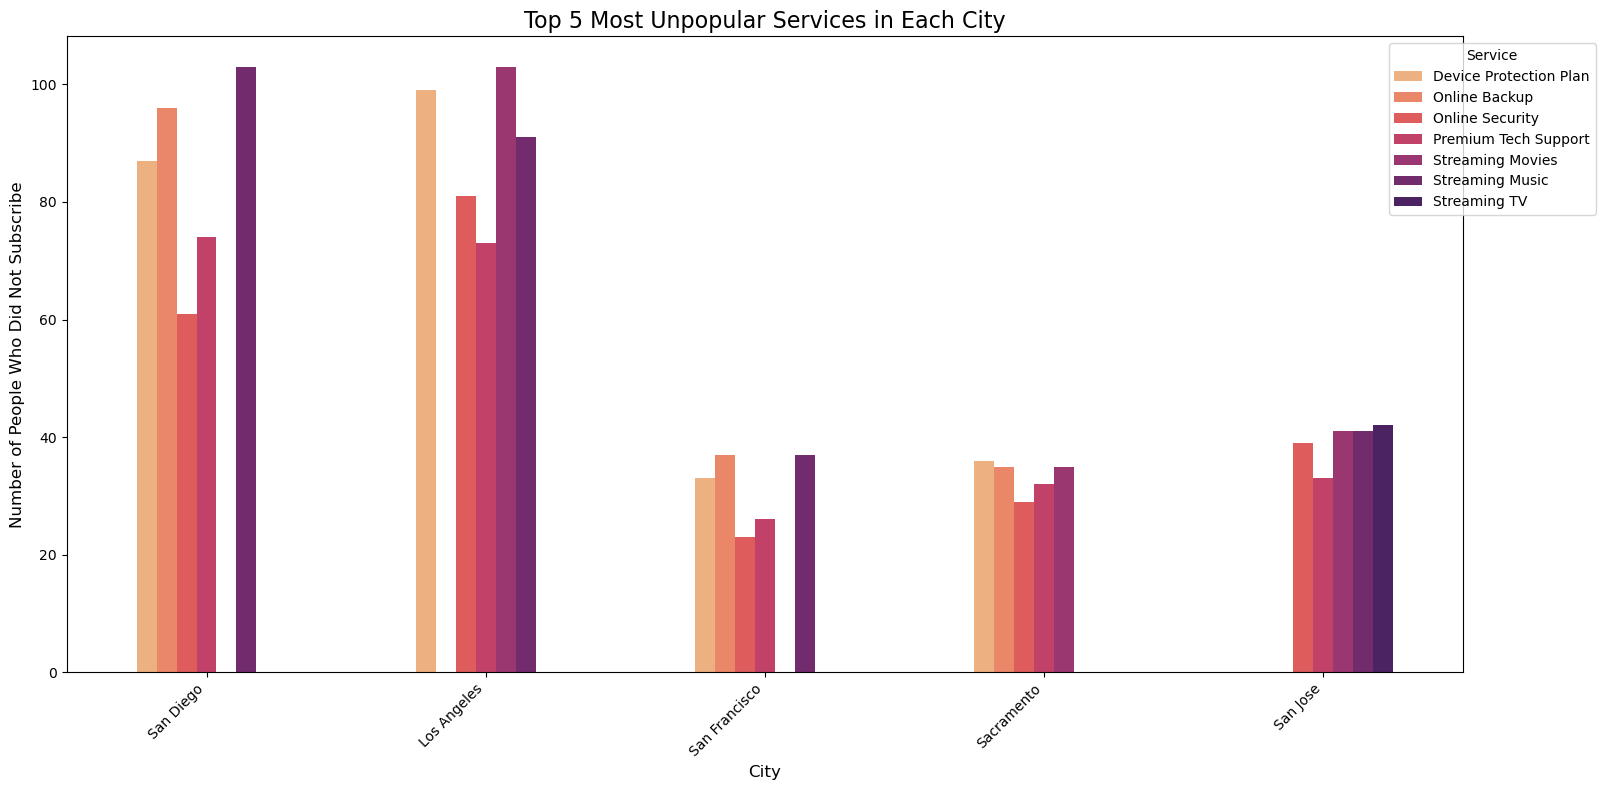

In [213]:
columns_to_convert = ['Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 
                      'Device Protection Plan', 'Premium Tech Support', 'Streaming TV', 
                      'Streaming Movies', 'Streaming Music', 'Unlimited Data']

df[columns_to_convert] = df[columns_to_convert].replace({'Yes': 1, 'No': 0}).astype(int)

cities_of_interest = ['San Diego', 'Los Angeles', 'San Francisco', 'Sacramento', 'San Jose']
top_services_per_city = {}

for city in cities_of_interest:
    city_data = df[df['City'] == city]
    service_counts = city_data[columns_to_convert].sum()
    top_5_services = service_counts.nsmallest(5)
    top_services_per_city[city] = top_5_services

top_services_df = pd.DataFrame(top_services_per_city).T
print(top_services_df)
top_services_df.plot(kind='bar', figsize=(16, 8), colormap='flare')
plt.title('Top 5 Most Unpopular Services in Each City', fontsize=16)
plt.xlabel('City', fontsize=12)
plt.ylabel('Number of People Who Did Not Subscribe', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Service', loc='upper right', bbox_to_anchor=(1.1, 1))
plt.tight_layout()
plt.show()

# Clustering

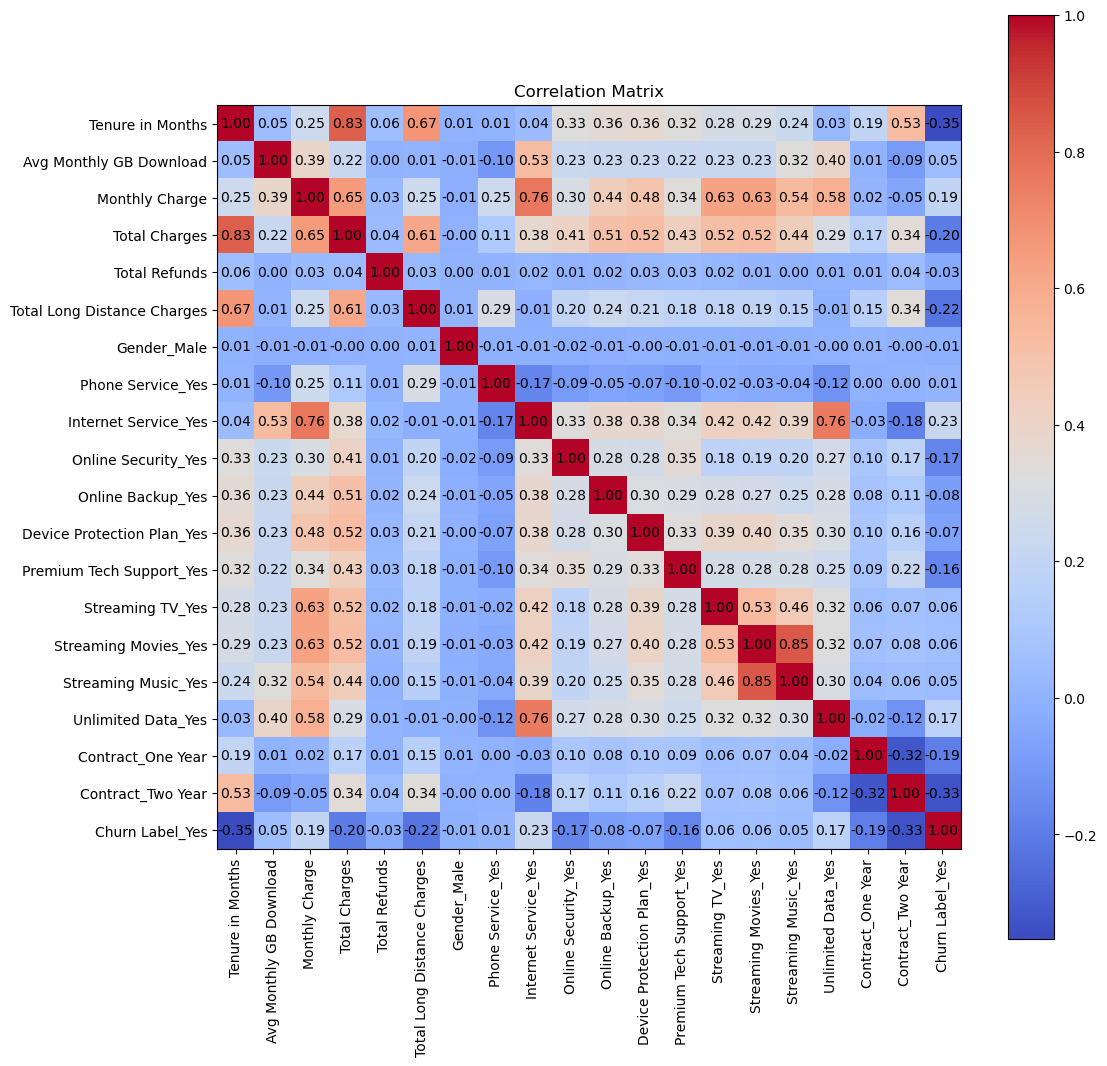

In [186]:
columns = [
    'Gender','Tenure in Months','Phone Service',
    'Internet Service','Avg Monthly GB Download', 
    'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
    'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract', 
    'Monthly Charge', 'Total Charges', 'Total Refunds', 
    'Total Long Distance Charges', 'Churn Label']
df_select = df[columns]
df_select = df_select.replace({'yes': 1, 'no': 0})
df_select = pd.get_dummies(df_select, drop_first=True)
corr_matrix = df_select.corr()

plt.figure(figsize=(12, 12))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.show()

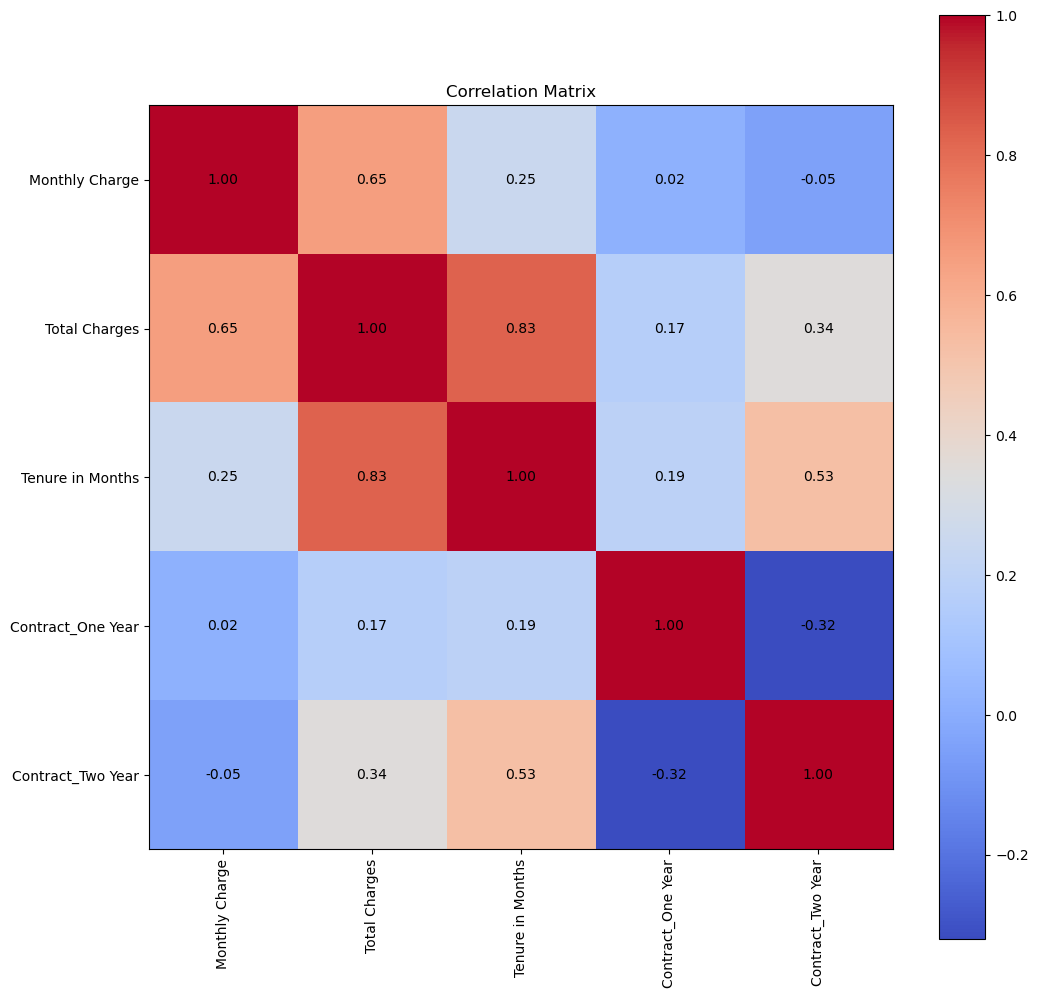

In [188]:
columns = ['Monthly Charge', 'Total Charges', 'Tenure in Months', 'Contract']
df_select = df[columns]
df_select = df_select.replace({'yes': 1, 'no': 0})
df_select = pd.get_dummies(df_select, drop_first=True)
corr_matrix = df_select.corr()

plt.figure(figsize=(12, 12))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.title('Correlation Matrix')
plt.show()

Optimal number of clusters: 2
จุดกึ่งกลางของแต่ละคลัสเตอร์ (Centroids):
   Monthly Charge  Total Charges  Tenure in Months  Cluster
0       52.124327     865.115004         20.040829        0
1       89.758562    5079.795877         56.807188        1


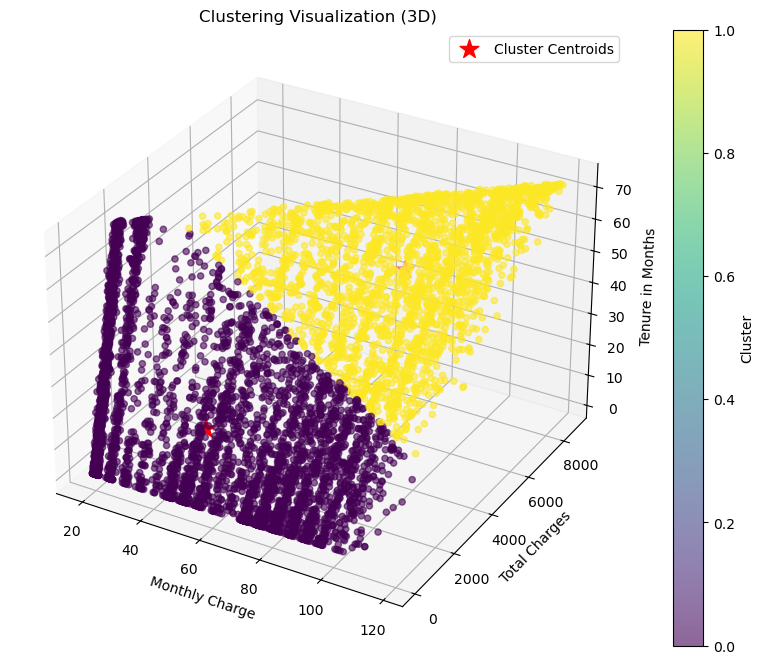

จำนวนผู้ใช้ Churn และ Stay ในแต่ละคลัสเตอร์:
Churn Label    No   Yes
Cluster                
0            3213  1469
1            1961   400


In [194]:
features = ['Monthly Charge', 'Total Charges', 'Tenure in Months']
df_selected = df[features]
df_selected = pd.get_dummies(df_selected, drop_first=True)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)
inertia = []
silhouette_scores = []
K_range = range(2, 21)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

# เลือกจำนวน cluster ที่ดีที่สุด
optimal_clusters = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_clusters}")

# ใช้ K-Means clustering ใหม่
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(df_scaled)


centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)

# แปลงเป็น DataFrame ให้ดูง่ายขึ้น
centroids_df = pd.DataFrame(centroids_original, columns=df_selected.columns)
centroids_df['Cluster'] = range(optimal_clusters)

# แสดงค่าจุดกึ่งกลางของแต่ละคลัสเตอร์
print("จุดกึ่งกลางของแต่ละคลัสเตอร์ (Centroids):")
print(centroids_df)
# ---- พล็อตกราฟแบบ 3 มิติ ----
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_selected['Monthly Charge'], df_selected['Total Charges'], df_selected['Tenure in Months'], 
                     c=df['Cluster'], cmap='viridis', alpha=0.6, s=20)

ax.scatter(centroids_original[:, 0], centroids_original[:, 1], centroids_original[:, 2],
           c='red', marker='*', s=200, label="Cluster Centroids")

ax.set_title('Clustering Visualization (3D)')
ax.set_xlabel('Monthly Charge')
ax.set_ylabel('Total Charges')
ax.set_zlabel('Tenure in Months')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()
churn_stay_summary = df.groupby(['Cluster', 'Churn Label']).size().unstack(fill_value=0)
print("จำนวนผู้ใช้ Churn และ Stay ในแต่ละคลัสเตอร์:")
print(churn_stay_summary)

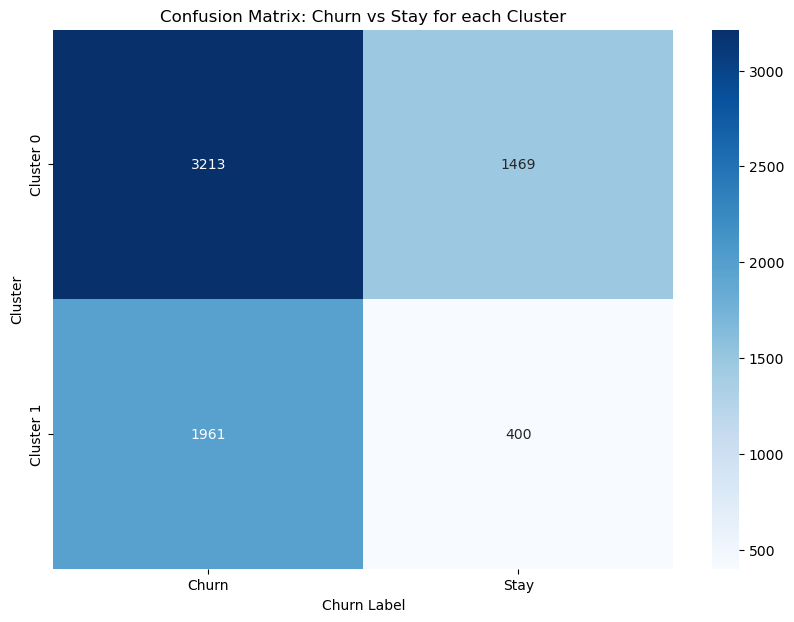

In [198]:
conf_matrix = confusion_matrix(df['Cluster'], df['Churn Label'].map({'Yes': 1, 'No': 0}))
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Churn', 'Stay'], yticklabels=[f'Cluster {i}' for i in range(optimal_clusters)])
plt.title('Confusion Matrix: Churn vs Stay for each Cluster')
plt.xlabel('Churn Label')
plt.ylabel('Cluster')
plt.show()

# Predictive 

In [203]:
le = LabelEncoder()
df['Contract'] = le.fit_transform(df['Contract'])
df['Churn Label Encoded'] = df['Churn Label'].map({'No': 0, 'Yes': 1})
X = df[['Monthly Charge', 'Tenure in Months', 'Contract', 'Total Charges', 'Satisfaction Score']] 
y = df['Churn Label Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ทำ SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# ทำ StandardScaler หลังจาก SMOTE
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

model = KNeighborsClassifier(n_neighbors=4, weights='distance', metric='manhattan')
model.fit(X_train_scaled, y_train_resampled)
y_pred = model.predict(X_test_scaled)

print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96      1552
           1       0.90      0.86      0.88       561

    accuracy                           0.94      2113
   macro avg       0.92      0.91      0.92      2113
weighted avg       0.94      0.94      0.94      2113



In [205]:
# จำนวนข้อมูลทั้งหมด
total_data = df.shape[0]

# จำนวนข้อมูลที่ใช้เทรน
train_data = X_train.shape[0]
churn_count = y_train.sum()  # จำนวน Churn ใน Training data ก่อน Upsampling
stay_count = len(y_train) - churn_count  # จำนวน Stay ใน Training data ก่อน Upsampling

# จำนวนข้อมูลที่ถูก Upsampled
upsample_data = X_train_resampled.shape[0]
upsample_churn_count = y_train_resampled.sum()  # จำนวน Churn ใน Training data หลัง Upsampling
upsample_stay_count = len(y_train_resampled) - upsample_churn_count  # จำนวน Stay ใน Training data หลัง Upsampling

# จำนวนข้อมูลที่ใช้ทดสอบ
test_data = X_test.shape[0]

# คำนวณสัดส่วน
train_ratio = train_data / total_data
test_ratio = test_data / total_data

# แสดงผล
print(f"Total data: {total_data} samples")
print(f"Training data: {train_data} samples ({train_ratio*100:.2f}%)")
print(f"Churn: {churn_count} samples ({churn_count / len(y_train) * 100:.2f}%)")
print(f"Stay: {stay_count} samples ({stay_count / len(y_train) * 100:.2f}%)")
print(f"Testing data: {test_data} samples ({test_ratio*100:.2f}%)")
print("After sampling (SMOTE)")
print(f"Training data: {upsample_data} samples")
print(f"Churn after SMOTE: {upsample_churn_count} samples ({upsample_churn_count / len(y_train_resampled) * 100:.2f}%)")
print(f"Stay after SMOTE: {upsample_stay_count} samples ({upsample_stay_count / len(y_train_resampled) * 100:.2f}%)")

Total data: 7043 samples
Training data: 4930 samples (70.00%)
Churn: 1308 samples (26.53%)
Stay: 3622 samples (73.47%)
Testing data: 2113 samples (30.00%)
After sampling (SMOTE)
Training data: 5433 samples
Churn after SMOTE: 1811 samples (33.33%)
Stay after SMOTE: 3622 samples (66.67%)


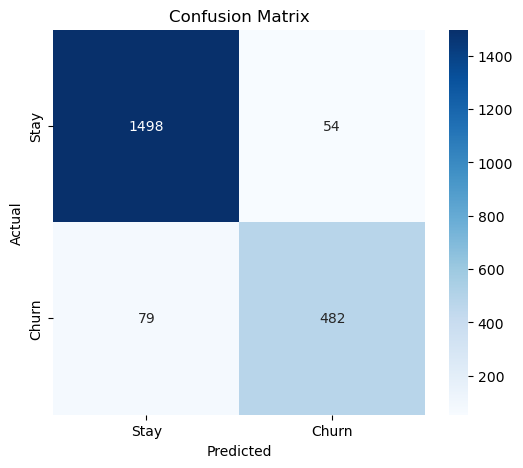

In [207]:
cm = confusion_matrix(y_test, y_pred)

# แสดง confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Churn'], yticklabels=['Stay', 'Churn'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [209]:
# ข้อมูลใหม่ที่ต้องการทำนาย Monthly Charge, Tenure in Months, Contract, Total Charges, Satisfaction Score
new_data = [[80, 4, 1, 320, 2]]
new_data_scaled = scaler.transform(new_data)
prediction = model.predict(new_data_scaled)
print(f'Churn Prediction: {"Churn" if prediction[0] else "Stay"}')

Churn Prediction: Churn


C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
